In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA

from Dennis.larvee.larvee_utils import plot_larvee


# 0. Define functions

# 1. Load Data

In [41]:
# Load data: 
# centered_data_v2_name = "../larvee_datasets_irina/centered/video2_centered.npy"
# centered_data_v3_name = "../larvee_datasets_irina/centered/video3_centered.npy"

centered_data_v2_name = "../larvee_datasets_irina/rotated/video2_rotated.npy"
centered_data_v3_name = "../larvee_datasets_irina/rotated/video3_rotated.npy"

centered_data_v2 = np.load(centered_data_v2_name)
centered_data_v3 = np.load(centered_data_v3_name)

cent_data_dict = {"pos_v2": centered_data_v2,
                  "pos_v3": centered_data_v3}

for k, v in cent_data_dict.items():
    print(k, v.shape)

pos_v2 (1938, 22, 2)
pos_v3 (2999, 22, 2)


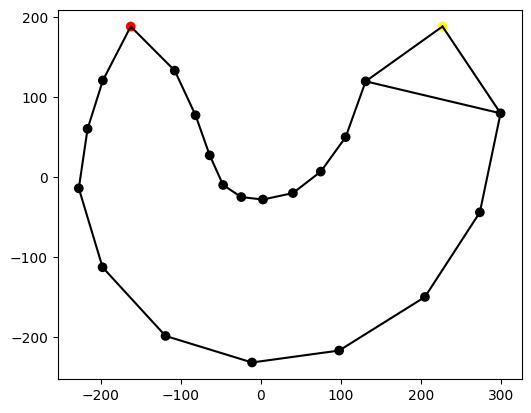

In [42]:
# plot one frame: 
frame = 100
data = cent_data_dict["pos_v3"]

plot_larvee.plot_single_frame_data(data[frame, :, :])

### 2.2: PCA analysis

In [43]:
# Do PCA: 
data_use = cent_data_dict["pos_v3"]

new_shape = (data_use.shape[0], data_use.shape[1] * data_use.shape[2])
data_for_pca = data_use.reshape(new_shape)
print(f"{data_for_pca.shape=}")
pca = PCA()

pca.fit(data_for_pca)

data_for_pca.shape=(2999, 44)


PCA()

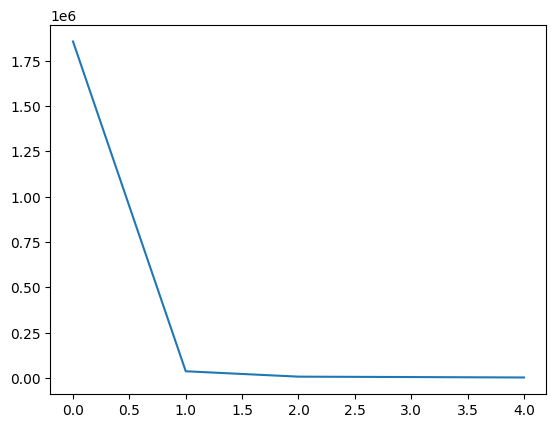

In [44]:
# Plot explained variance: 
evs = pca.explained_variance_
plt.plot(evs[:5])

In [45]:
# components: 
pcs = pca.components_  #n components x n_features
print(f"{pcs.shape=}")

pcs.shape=(44, 44)


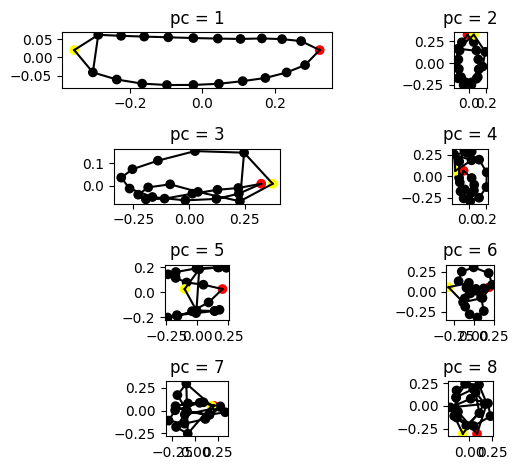

In [46]:
fig, axs = plt.subplots(4, 2)
axs = axs.flatten()
for i_ax, ax in enumerate(axs): 
    pc = pcs[i_ax, :]
    pc_reshaped = pc.reshape((data_use.shape[1:]))
    plot_larvee.plot_single_frame_data(pc_reshaped, ax)
    ax.set_title(f"pc = {i_ax+1}")
fig.tight_layout()

n_components =1
n_components =8
n_components =10
n_components =15
n_components =20


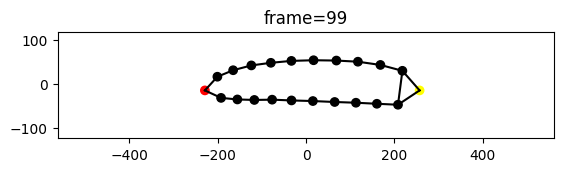

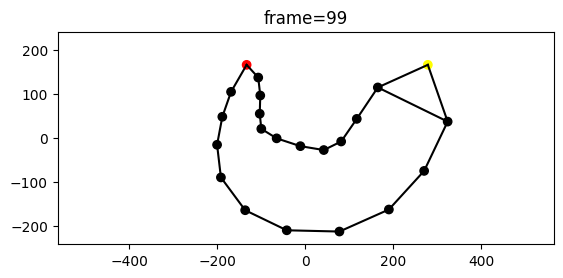

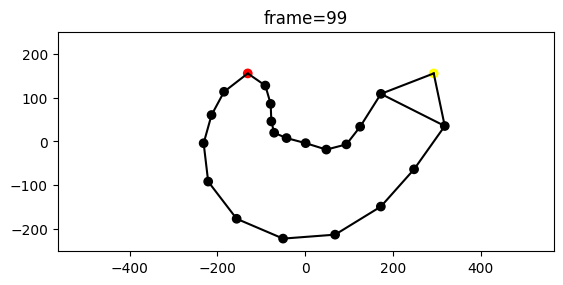

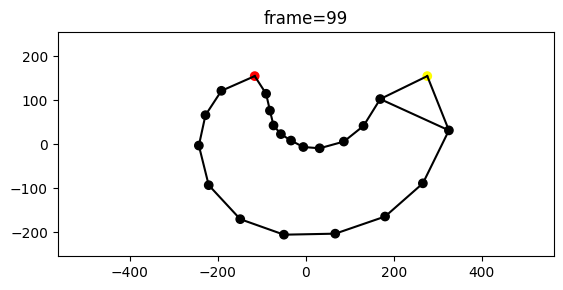

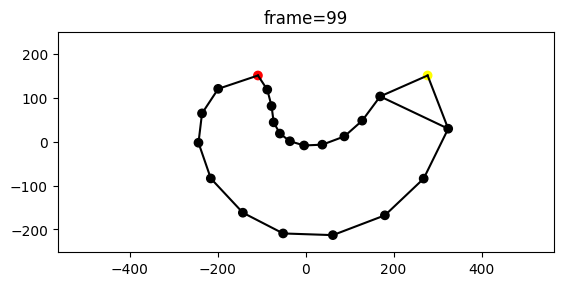

In [47]:
# reconstruction error:
nr_samples = data_use.shape[0]

for n_components in [1, 8, 10, 15, 20]:
    print(f"{n_components =}")
    
    pca = PCA(n_components=n_components)
    data_recon = pca.inverse_transform(pca.fit_transform(data_use.reshape(nr_samples, 44))).reshape((nr_samples, 22, 2))
    
    plot_larvee.animate_and_save(data=data_recon, 
                     file_name=f"pc_reconstruction/pc_reconstruction_v3__n_{n_components}.gif")

# 3. Maximally predictive states

In [14]:
import deeptime as dtime
import scipy

from utils_dennis.maximally_predictive_states import (time_delay_embedding, 
                                                      cluster_data, 
                                                      compare_time_series, 
                                                      get_entropy
                                                      )

#### 3.1 Prepare data

- Take the centered data of shape (timesteps, 22, 2) and transform it to (timesteps, 44). 

In [48]:
data_use = cent_data_dict["pos_v3"]
print(f"{data_use.shape=}")
X = data_use.reshape((data_use.shape[0], 44))
print(f"{X.shape=}")

data_use.shape=(2999, 22, 2)
X.shape=(2999, 44)


#### 3.2 Timedelay-embedding + clustering

In [52]:
delay = 2
n_clusters = 500

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="minibatchkmeans")
print(f"{labels.shape=}")
print(f"{centers.shape=}")

print(f"Delay = {delay} = {delay/5} seconds.")

traj_matrix.shape=(2997, 132)
labels.shape=(2997,)
centers.shape=(500, 132)
Delay = 2 = 0.4 seconds.


traj_matrix_reconstructed.shape=(2997, 132)


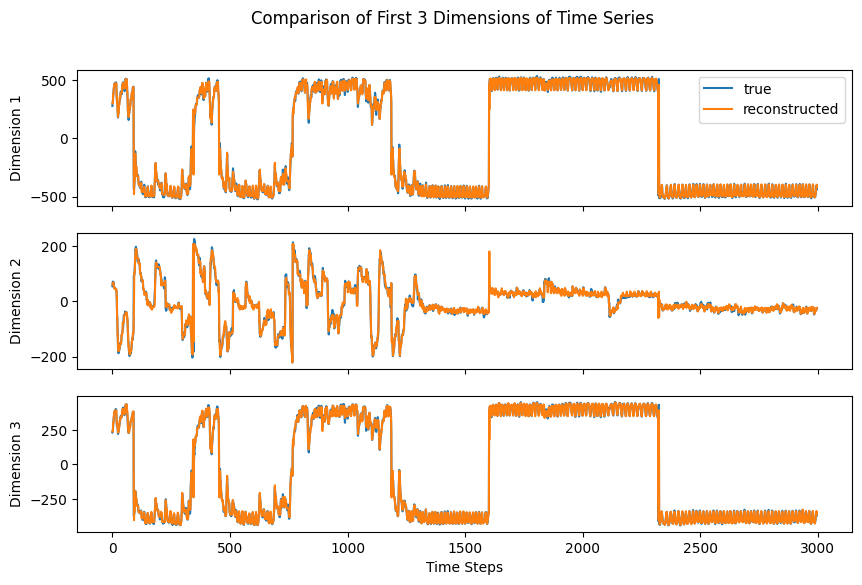

In [53]:
# reconstruct timeseries: 
traj_matrix_reconstructed = centers[labels, :]
print(f"{traj_matrix_reconstructed.shape=}")

# plot reconstruction: 
compare_time_series(traj_matrix[:, :], traj_matrix_reconstructed[:, :], k=3,
                    label1="true", label2="reconstructed")

#### 3.3 Create transition matrix with deeptime: 

Text(0, 0.5, 'states')

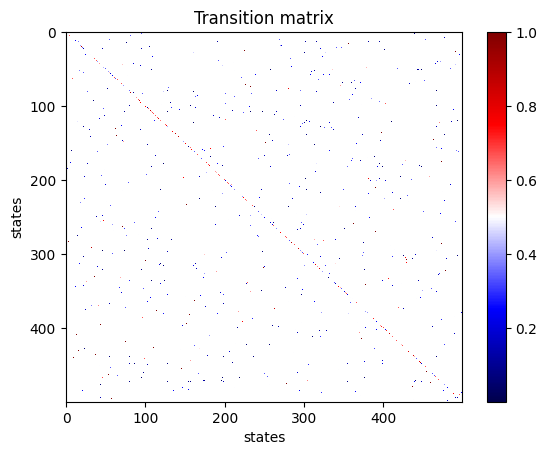

In [54]:
lag = 1

# count matrix: 
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=True)

P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(P.toarray(), cmap=cmap, interpolation='nearest', aspect='auto', vmin=0.0001,
           vmax=1)
plt.colorbar()
plt.title("Transition matrix")
plt.xlabel("states")
plt.ylabel("states")

#### 3.4 Sample Markov model

In [55]:
msm = dtime.markov.msm.MarkovStateModel(P)

start_time = 400

start_state_real_space = traj_matrix[[start_time], :]
print(f"{start_state_real_space.shape=}")
start_state_discrete = kmeans_model.predict(start_state_real_space)
print(f"{start_state_discrete.shape=}")

n_steps = 1000
simulated_labels = msm.simulate(n_steps=n_steps, start=start_state_discrete, dt=1,
                                seed=1)
print(f"{simulated_labels.shape=}")

simulated_real_space = centers[simulated_labels]
print(f"{simulated_real_space.shape=}")

start_state_real_space.shape=(1, 132)
start_state_discrete.shape=(1,)
simulated_labels.shape=(1000,)
simulated_real_space.shape=(1000, 132)


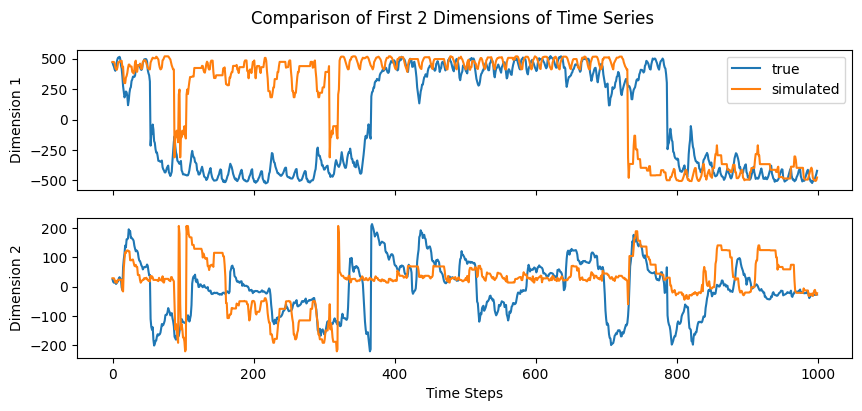

In [56]:
# plot reconstruction: 
time_window = 1000

compare_time_series(traj_matrix[start_time:start_time + time_window, :],
                    simulated_real_space[:time_window, :], k=2, label1="true",
                    label2="simulated")

In [57]:
reconstructed_larvee = simulated_real_space[:, :44].reshape((time_window, 22, 2))

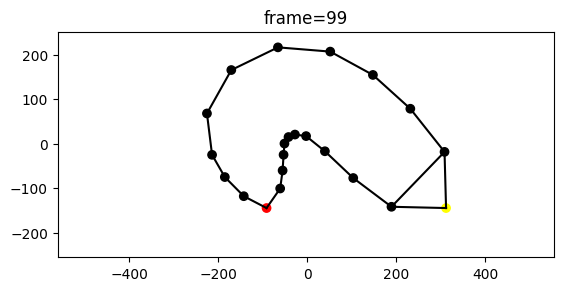

In [58]:
# Markov simulation: 

#calculate fps: 
fps = int(10/lag)

plot_larvee.animate_and_save(data=reconstructed_larvee, 
                 file_name=f"markov_larvee/markov_larvee_v3.gif", 
                 fps=fps)

#### 3.5 Define entropy function as a function of the transition matrix: 

In [59]:
# Calculate entropy of labels: 

get_entropy(transition_matrix=P)

0.9339688501764065

In [60]:
# Calculate entropy for various delays and number of clusters. 
lag_use = 1

delay_list = np.arange(0, 30, 4, dtype=int)
n_clusters_list = np.array(np.logspace(2, 3, 4), dtype=int)
# n_clusters_list = np.array([100, 200, 500, 1000, 1500], dtype=int)
entropy_data = np.zeros((len(delay_list), len(n_clusters_list)))
for i_delay, delay in enumerate(delay_list):
    traj_matrix_use = time_delay_embedding(data=X, delay=delay)
    for i_n_clusters, n_clusters in enumerate(n_clusters_list):
        labels_use, _, _ = cluster_data(data=traj_matrix_use, n_clusters=n_clusters,
                                        random_state=1, algorithm="minibatchkmeans")
        C_use = dtime.markov.tools.estimation.count_matrix(labels_use,
                                                           lag=lag_use,
                                                           sliding=True)
        C_use = dtime.markov.tools.estimation.largest_connected_submatrix(C_use, directed=True)
        print(f"{C_use.shape=}")
        connected_bool = dtime.markov.tools.analysis.is_connected(C_use, directed=True)
        print(f"{connected_bool=}")
        P_use = dtime.markov.tools.estimation.transition_matrix(C_use, reversible=False)
        entropy = get_entropy(P_use)
        entropy_data[i_delay, i_n_clusters] = entropy
        print(f"Computed for {delay} delays and {n_clusters} clusters. entropy={entropy:.3f}\n")

C_use.shape=(100, 100)
connected_bool=True
Computed for 0 delays and 100 clusters. entropy=0.890
C_use.shape=(215, 215)
connected_bool=True
Computed for 0 delays and 215 clusters. entropy=1.065
C_use.shape=(455, 455)
connected_bool=True
Computed for 0 delays and 464 clusters. entropy=1.067
C_use.shape=(981, 981)
connected_bool=True
Computed for 0 delays and 1000 clusters. entropy=0.909
C_use.shape=(99, 99)
connected_bool=True
Computed for 4 delays and 100 clusters. entropy=0.813
C_use.shape=(214, 214)
connected_bool=True
Computed for 4 delays and 215 clusters. entropy=0.913
C_use.shape=(458, 458)
connected_bool=True
Computed for 4 delays and 464 clusters. entropy=0.950
C_use.shape=(951, 951)
connected_bool=True
Computed for 4 delays and 1000 clusters. entropy=0.775
C_use.shape=(100, 100)
connected_bool=True
Computed for 8 delays and 100 clusters. entropy=0.786
C_use.shape=(214, 214)
connected_bool=True
Computed for 8 delays and 215 clusters. entropy=0.873
C_use.shape=(458, 458)
connect

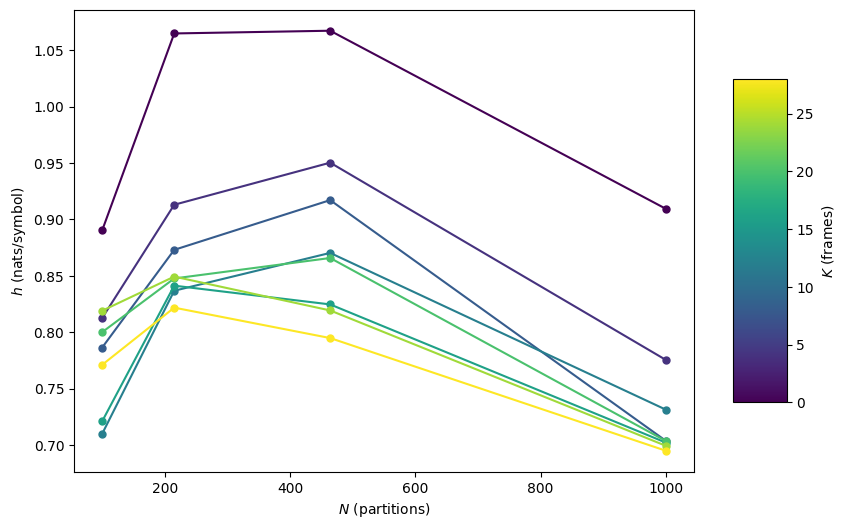

delay_list=array([ 0,  4,  8, 12, 16, 20, 24, 28])
n_clusters_list=array([ 100,  215,  464, 1000])
max_h_K=array([1.06741947, 0.95037348, 0.91714262, 0.87031384, 0.84124571,
       0.86579461, 0.84928782, 0.82175045])


In [61]:
# lot entropy vs n_clusters and delays. 
colors_K = plt.cm.viridis(np.linspace(0, 1, len(delay_list)))
max_h_K = np.zeros(len(delay_list))
cil_h_K = np.zeros(len(delay_list))
ciu_h_K = np.zeros(len(delay_list))
max_idx_array = np.zeros(len(delay_list), dtype=int)
plt.figure(figsize=(10, 6))

for k in range(len(delay_list)):
    plt.errorbar(n_clusters_list, entropy_data[k], c=colors_K[int(k)], capsize=4,
                 marker='o', ms=5)
    max_idx = np.argmax(entropy_data[k])
    max_idx_array[k] = int(max_idx)
    max_h_K[k] = entropy_data[k][max_idx]

plt.scatter(n_clusters_list, entropy_data[k], c=entropy_data[k], vmin=min(delay_list),
            vmax=max(delay_list), s=0)
plt.colorbar(shrink=.7, aspect=6, label='$K$ (frames)')
plt.xlabel('$N$ (partitions)')
plt.ylabel('$h$ (nats/symbol)')
#plt.xscale('log')
plt.show()

print(f"{delay_list=}")
print(f"{n_clusters_list=}")
print(f"{max_h_K=}")

n_cluster = 464


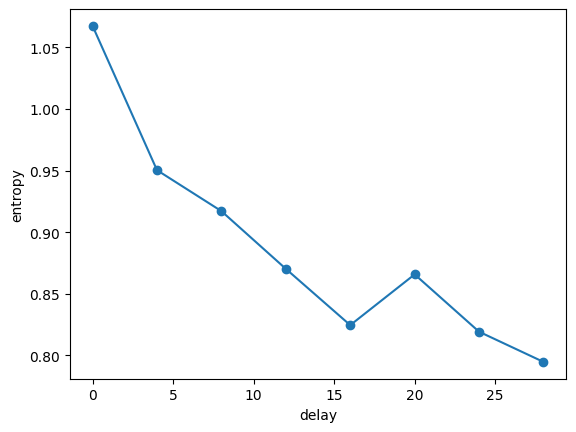

In [62]:
n_cluster_index = 2
plt.plot(delay_list, entropy_data[:, n_cluster_index], marker='o')
plt.xlabel("delay")
plt.ylabel("entropy")
print(f"n_cluster = {n_clusters_list[n_cluster_index]}")